<a href="https://colab.research.google.com/github/Agamemnommom/Churn-Prediction-Service/blob/notebooks/Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# =====================================
# 🧑‍💻 UNIVERSAL ML PROJECT TEMPLATE
# =====================================

# 1. Импорты
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix,
    mean_squared_error, r2_score, classification_report
)

# Базовые модели (можно добавлять свои)
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Для балансировки (если нужно)
from imblearn.over_sampling import SMOTE

# Для визуализации важности признаков
import shap

# =====================================


In [2]:
# 2. Загрузка данных
# =====================================
# Пример: df = pd.read_csv("data.csv")
df = pd.read_csv("/content/customer_churn_dataset-training-master.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  object 
 8   Contract Length    440832 non-null  object 
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB


In [4]:
df['Gender'].value_counts()

,count
Gender,
Male,250252
Female,190580


In [5]:
df.describe()


,CustomerID,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
count,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000
mean,225398.667955,39.373153,31.256336,15.807494,3.604437,12.965722,631.616223,14.480868,0.567107
std,129531.918550,12.442369,17.255727,8.586242,3.070218,8.258063,240.803001,8.596208,0.495477
min,2.000000,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,113621.750000,29.000000,16.000000,9.000000,1.000000,6.000000,480.000000,7.000000,0.000000
50%,226125.500000,39.000000,32.000000,16.000000,3.000000,12.000000,661.000000,14.000000,1.000000
75%,337739.250000,48.000000,46.000000,23.000000,6.000000,19.000000,830.000000,22.000000,1.000000
max,449999.000000,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


In [6]:
df.drop(columns='CustomerID', inplace=True) # removing unnecessary colum

In [7]:
df

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.00,17.0,1.0
1,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.00,6.0,1.0
2,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.00,3.0,1.0
3,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.00,29.0,1.0
4,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.00,20.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
440828,42.0,Male,54.0,15.0,1.0,3.0,Premium,Annual,716.38,8.0,0.0
440829,25.0,Female,8.0,13.0,1.0,20.0,Premium,Annual,745.38,2.0,0.0
440830,26.0,Male,35.0,27.0,1.0,5.0,Standard,Quarterly,977.31,9.0,0.0
440831,28.0,Male,55.0,14.0,2.0,0.0,Standard,Quarterly,602.55,2.0,0.0


In [8]:
#Рассмотрим пропущенные значения:
df.isnull().sum()

,0
Age,1
Gender,1
Tenure,1
Usage Frequency,1
Support Calls,1
Payment Delay,1
Subscription Type,1
Contract Length,1
Total Spend,1
Last Interaction,1


In [9]:
df[df.isna().any(axis=1)]

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
199295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
#Уберём эту единственную строчку:
df.dropna(inplace=True)

In [11]:
df.columns

Index(['Age', 'Gender', 'Tenure', 'Usage Frequency', 'Support Calls',
       'Payment Delay', 'Subscription Type', 'Contract Length', 'Total Spend',
       'Last Interaction', 'Churn'],
      dtype='object')

In [12]:
#Заметим, что все данные имеют тип float, хотя по сути своей почти все целочислены. Исправим это
some_set = ['Age', 'Tenure', 'Usage Frequency', 'Support Calls',
       'Payment Delay',
       'Last Interaction', 'Churn']
for word in some_set:
  df[word] = df[word].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 440832 entries, 0 to 440832
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Age                440832 non-null  int64  
 1   Gender             440832 non-null  object 
 2   Tenure             440832 non-null  int64  
 3   Usage Frequency    440832 non-null  int64  
 4   Support Calls      440832 non-null  int64  
 5   Payment Delay      440832 non-null  int64  
 6   Subscription Type  440832 non-null  object 
 7   Contract Length    440832 non-null  object 
 8   Total Spend        440832 non-null  float64
 9   Last Interaction   440832 non-null  int64  
 10  Churn              440832 non-null  int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 40.4+ MB


In [13]:
#Функции для визуализации однофакторного анализа

def make_histogram(df, target_feature, bins = 10, custom_ticks=None, unit='', additional=''):
    plt.figure(figsize=(10, 5))
    plt.hist(df[target_feature], bins=bins)
    if custom_ticks is not None:
        plt.xticks(custom_ticks)
    plt.ylabel('Количество')
    plt.xlabel(target_feature)
    plt.title(f"Распределение {target_feature.lower()}{additional}:\n")
    plt.grid()
    plt.show()
    print(
    f"Распределение {target_feature.lower()}{additional}: "
    f"{df[target_feature].mean():.2f} ± {df[target_feature].median():.2f} {unit}\n"
    f"Медиана: {df[target_feature].median():.2f} {unit}\n"
    f"Минимум: {df[target_feature].min()} {unit}\n"
    f"Максимум: {df[target_feature].max()} {unit}\n"
    f"{df[target_feature].skew():.3f} Ассиметрия(выброс)\n"
    )

def make_piechart(df, target_feature, additional=''):
    dict_of_val_counts = dict(df[target_feature].value_counts())
    data = list(dict_of_val_counts.values())
    keys = list(dict_of_val_counts.keys())

    palette_color = sns.color_palette('bright')
    plt.pie(data, labels=keys, colors=palette_color, autopct='%.0f%%')
    plt.title(f"Распределение клиентов {target_feature}:")
    plt.show()
    print_str = f"Распределение клиентов {target_feature.lower()}{additional}:"
    for k, v in zip(keys, data):
        print_str += f"\n{v} {k}"
    print(print_str)

def make_barplot(df, target_feature, custom_ticks=None, unit='', additional=''):
    plt.figure(figsize=(10, 5))
    dict_of_val_counts = dict(df[target_feature].value_counts())
    data = list(dict_of_val_counts.values())
    keys = list(dict_of_val_counts.keys())
    plt.bar(keys, data)
    if custom_ticks is not None:
        plt.xticks(custom_ticks)
    plt.xlabel(f'{target_feature.capitalize()}{additional}')
    plt.ylabel('Частота')
    plt.title(f"Распределение клиентов {target_feature.lower()}{additional}\n")
    plt.grid(axis='y')
    plt.show()
    print(f"Распеределение клиентов {target_feature.lower()}{additional}: {df[target_feature].mean():.2f} ± {df[target_feature].median():.2f} {unit}\nMedian: {df[target_feature].median():.2f} {unit}\nMinimum: {df[target_feature].min()} {unit}\nMaximum: {df[target_feature].max()} {unit}\n\n{df[target_feature].skew():.3f} Skewness\n")

def make_boxplot(df, feature):
    plt.figure(figsize=(10,5))
    sns.boxplot(df, x=feature)
    plt.title(f"Boxplot: {feature}\n")
    plt.xlabel(feature)
    plt.ylabel("Значения")
    plt.show()

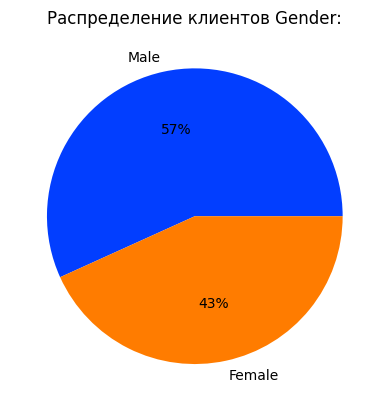

Распределение клиентов gender:
250252 Male
190580 Female


In [14]:
make_piechart(df, 'Gender')

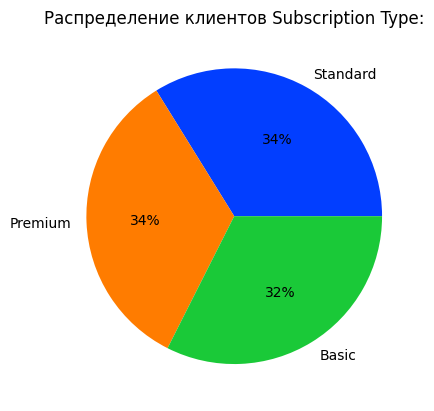

Распределение клиентов subscription type:
149128 Standard
148678 Premium
143026 Basic


In [15]:
make_piechart(df, 'Subscription Type')

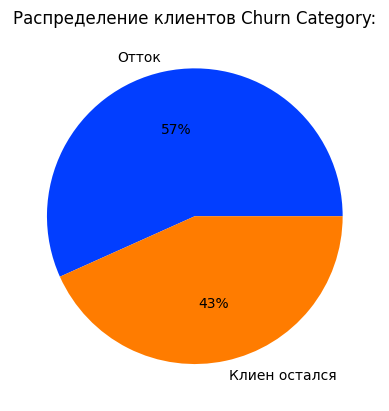

Распределение клиентов churn category:
249999 Отток
190833 Клиен остался


In [16]:
filtered = df.copy()
filtered['Churn Category'] = ['Отток' if x == 1.0 else 'Клиен остался' for x in df['Churn']]
make_piechart(filtered, 'Churn Category')

###  В наборе данных содержится больше записей об ушедших клиентах.

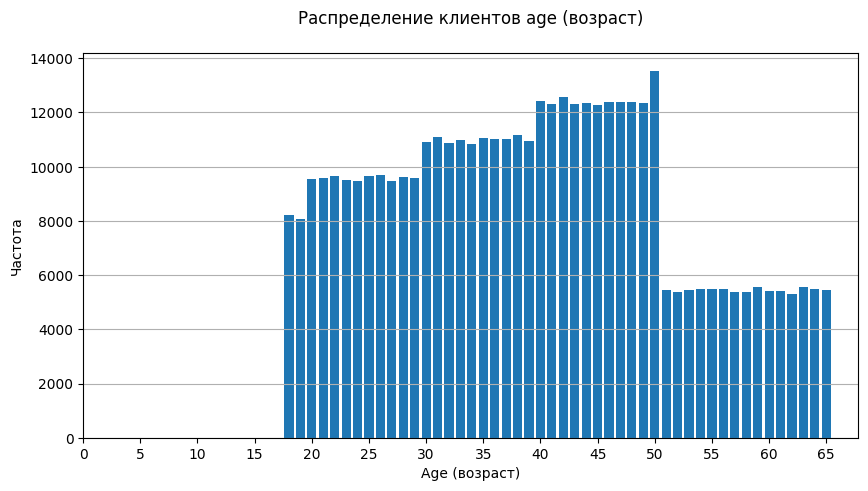

Распеределение клиентов age (возраст): 39.37 ± 39.00 возраст
Median: 39.00 возраст
Minimum: 18 возраст
Maximum: 65 возраст

0.162 Skewness



In [17]:
make_barplot(df, 'Age', custom_ticks=np.arange(0, 66, 5), additional=' (возраст)', unit='возраст')

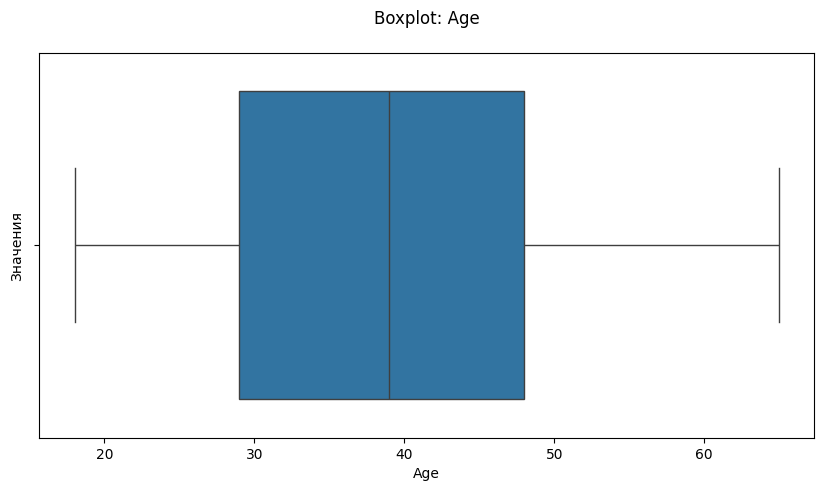

In [18]:
make_boxplot(df, 'Age')

### **Большинство клиентов — люди в возрасте 40–50 лет, причём чаще всего это люди в возрасте 50 лет. Количество клиентов в возрасте 51 года и старше крайне мало.**


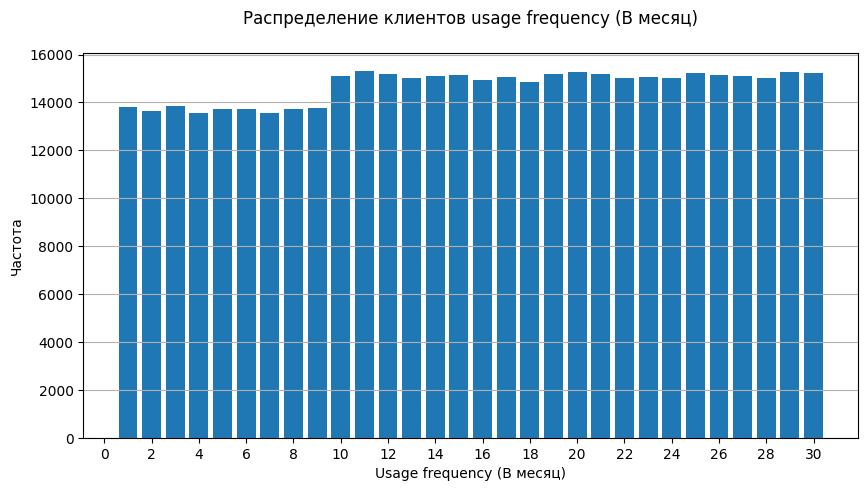

Распеределение клиентов usage frequency (В месяц): 15.81 ± 16.00 Время
Median: 16.00 Время
Minimum: 1 Время
Maximum: 30 Время

-0.043 Skewness



In [19]:
make_barplot(df, 'Usage Frequency', custom_ticks=np.arange(0, 31, 2), unit='Время', additional=' (В месяц)')

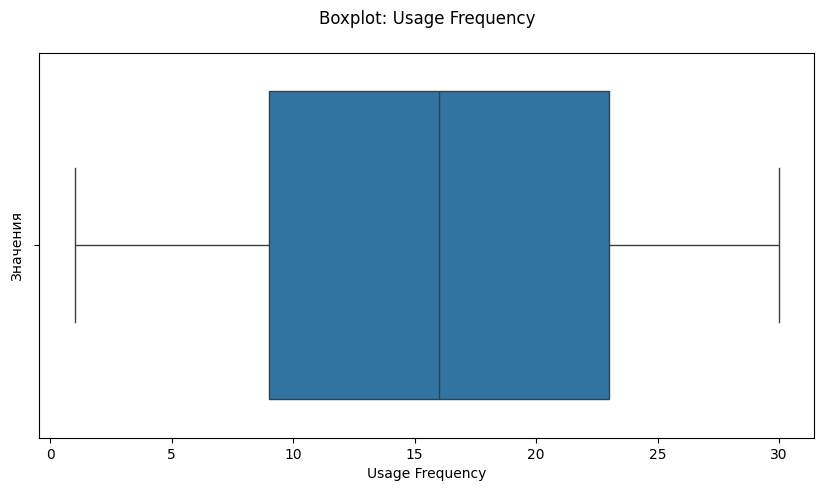

In [20]:
make_boxplot(df, 'Usage Frequency')

### **В среднем клиенты пользуются услугами компании 16 раз в месяц, при этом индивидуальная частота использования сильно разнится, что скорее всео говорит о различных привычках потребления услуг.**

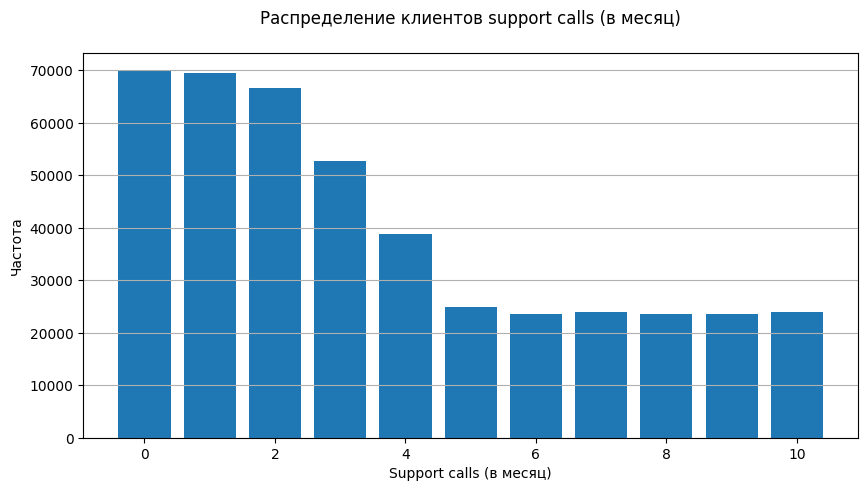

Распеределение клиентов support calls (в месяц): 3.60 ± 3.00 звонки
Median: 3.00 звонки
Minimum: 0 звонки
Maximum: 10 звонки

0.667 Skewness



In [21]:
make_barplot(df, 'Support Calls', unit='звонки', additional=' (в месяц)')

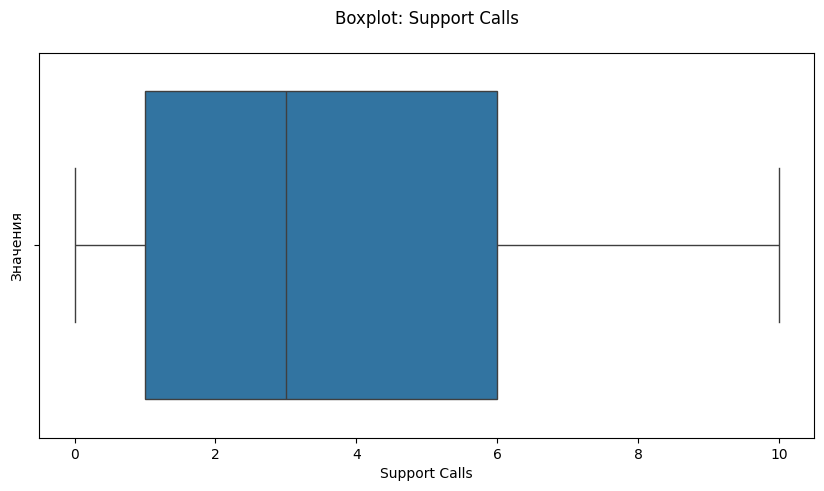

In [24]:
make_boxplot(df, 'Support Calls')

### Видим, что клиенты обращаются в тех поддержку три раза. Но в общем распеределении многие клиенты вообще не обращаются

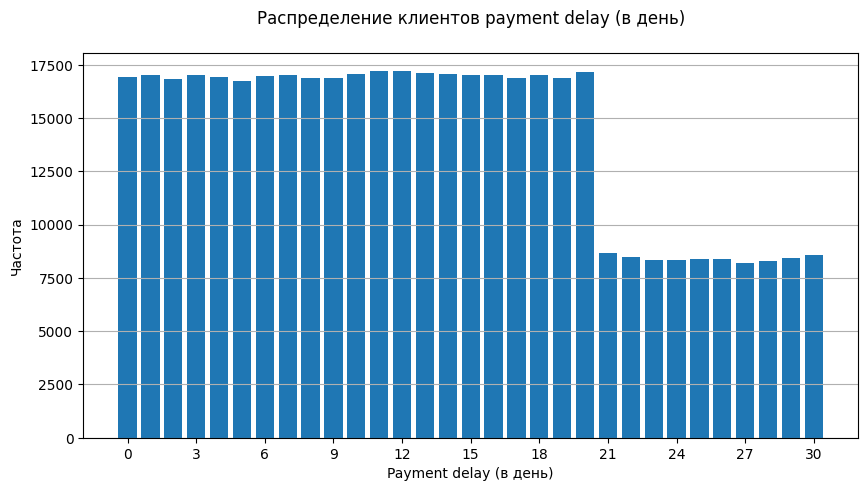

Распеределение клиентов payment delay (в день): 12.97 ± 12.00 days
Median: 12.00 days
Minimum: 0 days
Maximum: 30 days

0.267 Skewness



In [25]:
make_barplot(df, 'Payment Delay', custom_ticks=np.arange(0, 32, 3), unit='days', additional=' (в день)')

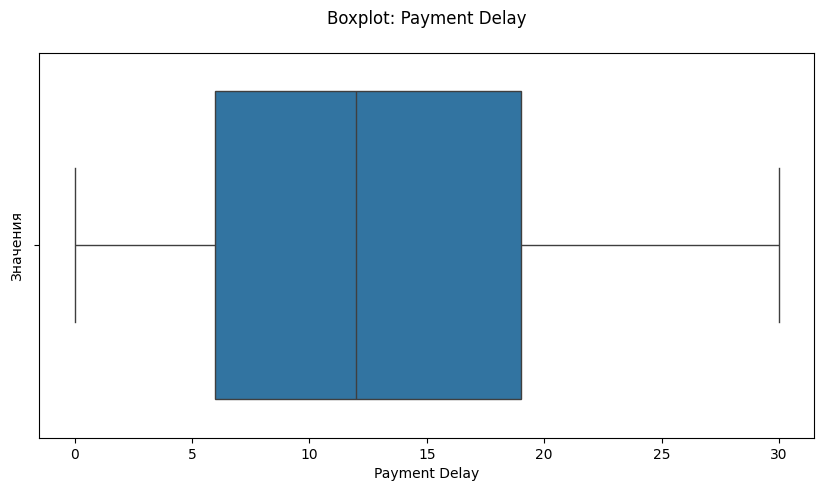

In [26]:
make_boxplot(df, 'Payment Delay')

### В среднем клиенты задерживают платежи на 13 дней. Большинство клиентов платят в течение 20 дней.

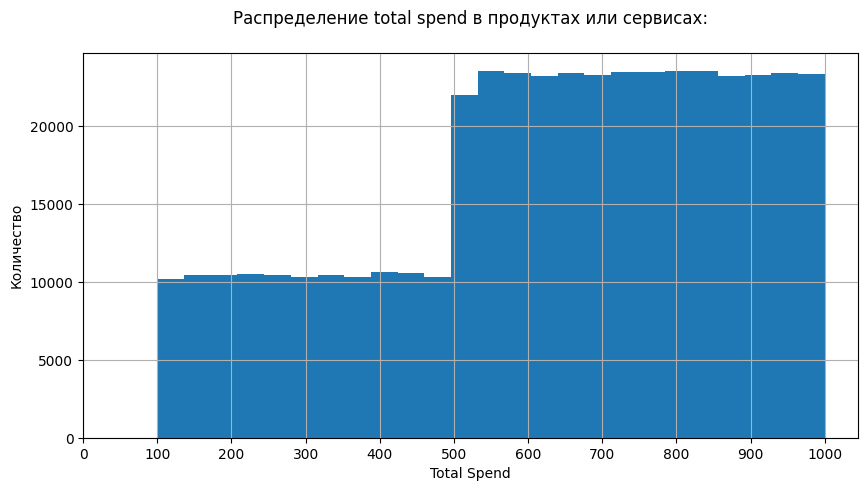

Распределение total spend в продуктах или сервисах: 631.62 ± 661.00 USD
Медиана: 661.00 USD
Минимум: 100.0 USD
Максимум: 1000.0 USD
-0.457 Ассиметрия(выброс)



In [29]:
# Рассмотрим теперь непрерывные распеределения, где большая вариабельность выходов
make_histogram(df, 'Total Spend', bins=25, custom_ticks=np.arange(0, 1001, 100), unit='USD', additional=" в продуктах или сервисах")

### В среднем клиент тратит 661$. Большинство больше 500. Если мы посмотрим на гистограмму, то ясно увидим, что разделение между клиентами, которые тратят больше и меньше, составляет около 500. Мы можем использовать это, чтобы разделить клиентов на клиентов с высокой ценностью (общая стоимость выше 500) и клиентов с низкой ценностью

In [ ]:
# Перейдём к многофакторному анализу.
